# Introduction

Implement the convolution of a Laplacian of a Gaussian blob (LoG) detector with an image and apply it to 3-4 images of your choice from the dataset (possibly from different thematic classes). Do not use library functions for implementing the convolution or to generate the LoG filter. Implement your own and show the code (the interesting bits at least)! The function you implement should be able to run the LoG for different choices of the scale parameter, which is passed as an input argument. Show the results of your code on the 3-4 example images, for different choices of the scale parameter (sigma).

The code of the module "blob_utils" and this notebook executed can be found on GitHub https://github.com/matteotolloso/ispr or Google Colab ?????

Useful libraries, "blob utils" that contains the core is writted by me.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import latexify
import cv2
import blob_utils

# Code explanation

## LoG function

Definition of the Laplacian of Gaussian (LoG) function:

In [3]:
@latexify.function(use_math_symbols=True)
def LoG(x, y, sigma):
    pi = np.pi
    return ((- 1 / (pi * sigma**4) ) * (1 - (x**2 + y**2) / (2 * sigma**2) ) ) * np.exp(-( (x**2 + y**2) / (2 * sigma**2)))
LoG

## Kernel building

Building the kernel sampling the function. The kernel must be big enough to cover both the positive and negative part of the function, otherwise we will not be able to detect the blobs. 

In [4]:
KERNEL_SIZE = 51
SIGMA = 14
PATH = "easy.png"
kernel = blob_utils.get_kernel(fun=LoG, size=KERNEL_SIZE, sigma=SIGMA)

## Image preprocessing

Transform the image to grayscale

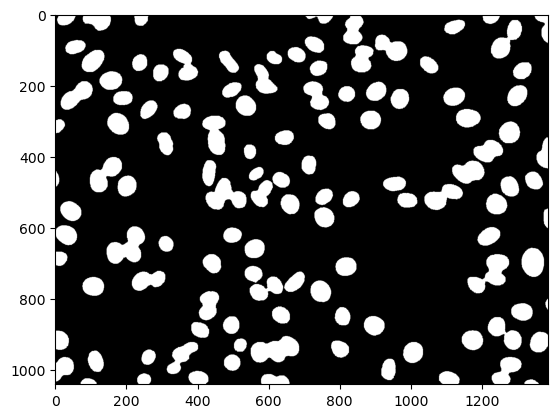

In [5]:
rgb_image = cv2.imread(PATH)
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY) 
plt.imshow(gray_image, cmap="gray")

Scaling of the image values between -1 and 1 in order to more easily interpret subsequent results.

In [6]:
gray_image = np.interp(
    gray_image, 
    (gray_image.min(), gray_image.max()), 
    (-1, 1)
)

## Convolution

Convolution step. A pixel in the convolved matrix is the value of the sum of the element-wise matrix multiplication between the submatrix of the original image centered in that pixel and the kernel.

If the image has a blob of the kind "dark inside, bright ouside" the center of that blob in the convolved matrix will have an high value since the dark part (negative) is multiplied by the center of the LoG (negative) and the bright part (positive) is multiplied by the positive circular part of the LoG.

For the same reason the blobs of the kind "bright inside, dark outside" will be identified by a low value in the convolved matrix.

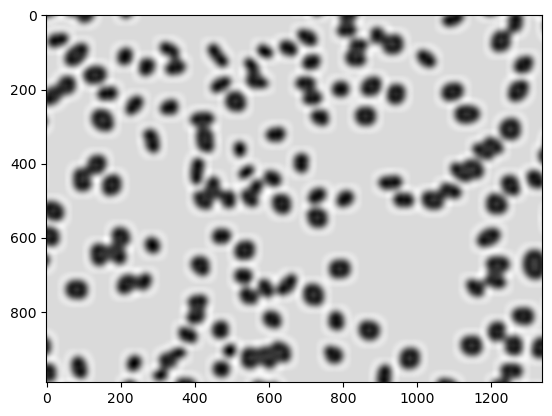

In [7]:
convolved_image = blob_utils.convolve_image(
    padded_image=gray_image, 
    kernel=kernel
)
plt.imshow(convolved_image, cmap="gray")

As you can see, the black backgrond (value -1) became gray since the high response with the negative center of the kernel, and for the same season, the white circles became light black. In the center of the circles there are some white pixels.

Theoretically, if the blob rasius inducted by sigma perfectly matches the size of the blobs in the image, the value at the center of the blobs in the colvolved image should be greater in absolute value compared to the value of the background, but since it's difficult to match the correct sigma and in addiction the blobs are never perfectly cercular, could happen that the if we use the global minima and maxima ad blob center nothing significant is captured.

Another issue is that a group of pixels in the center of a blob could have an high value (with respect to the rest of the convolved image), and we have to choose wich one will be the center of the blob.


## Finding the blob centers

To address these issues, we are look for local minima and maxima, in particular strictly maxima and minima i.e. a point of the convolved image is the center of a blob if it is strictly greater (minor) that all other points in the blob radius.

In the function there is also the possibility to set a treshold based on the percentile in order to decide the number of blobs that we want to see.

In [8]:
blob_radius = int (np.sqrt(2) * SIGMA) + 1
centers = blob_utils.get_centers(
    convolved_image, 
    blob_radius=blob_radius, 
    kernel_size=kernel.shape[0], 
    percentile=np.percentile(convolved_image, [40, 60])
)

## Final result drawing

The blobs given by a local mimium are circled in green, while the ones given by a local maximum are red

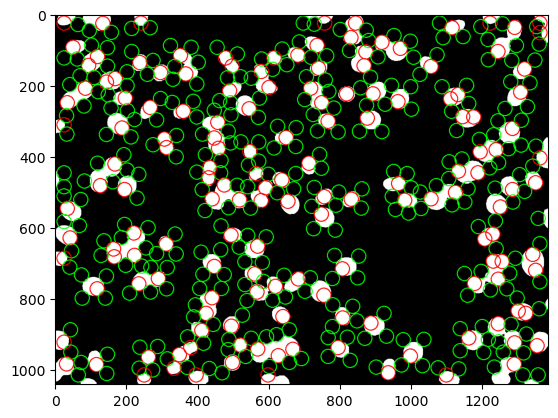

In [9]:
rgb_image = cv2.imread(PATH)
for (i, j , _, tipo) in centers:
    if tipo=="min":
        color = (255, 0, 0)
    else:
        color = (0, 255, 0)   
    cv2.circle(
        rgb_image, 
        (j, i), 
        blob_radius, 
        color, 
        thickness=2, 
        lineType=2
    )

plt.imshow(rgb_image, cmap="gray")

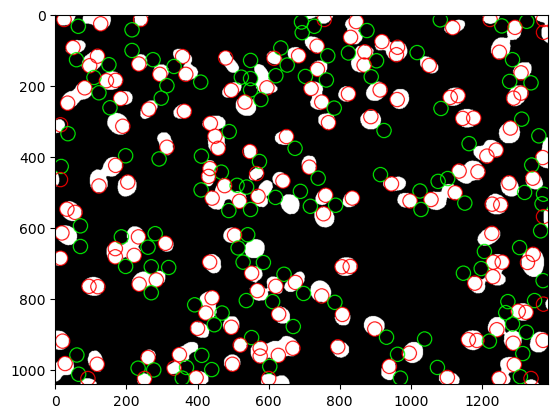

In [10]:
import blob_utils
blob_utils.full_pipeline(
    path="easy.png", 
    kernel_size = 31, 
    sigma = 14,
    percentile = (30, 70)
)